Leyendo Excel: c:\Users\Lenovo\Prueba python\senamhi_by_station.xlsx
  -> hoja 'Campo_De_Marte_MET_EMA' cargada como 'Campo De Marte' (43194 filas válidas).
  -> hoja 'Carabayllo_MET_EMA' cargada como 'Carabayllo' (39135 filas válidas).
  -> hoja 'Ceres_MET_EMA' cargada como 'Ceres' (22799 filas válidas).
  -> hoja 'Las_Palmas_MET_EMA' cargada como 'Las Palmas' (20418 filas válidas).
  -> hoja 'Pantanos_De_Villa_MET_EMA' cargada como 'Pantanos De Villa' (27899 filas válidas).
  -> hoja 'San_Borja_MET_EMA' cargada como 'San Borja' (38678 filas válidas).
  -> hoja 'San_Martin_De_Porres_MET_EAA' cargada como 'San Martin De Porres EAA' (42607 filas válidas).

Estaciones disponibles:
 0) ALL (todas las estaciones, se promedian por fecha/hora)
 1) Campo De Marte
 2) Carabayllo
 3) Ceres
 4) Las Palmas
 5) Pantanos De Villa
 6) San Borja
 7) San Martin De Porres EAA

Seleccionado: Pantanos De Villa
Primeras filas (temperatura):
                     TEMPERATURA (°C)
__datetime                 

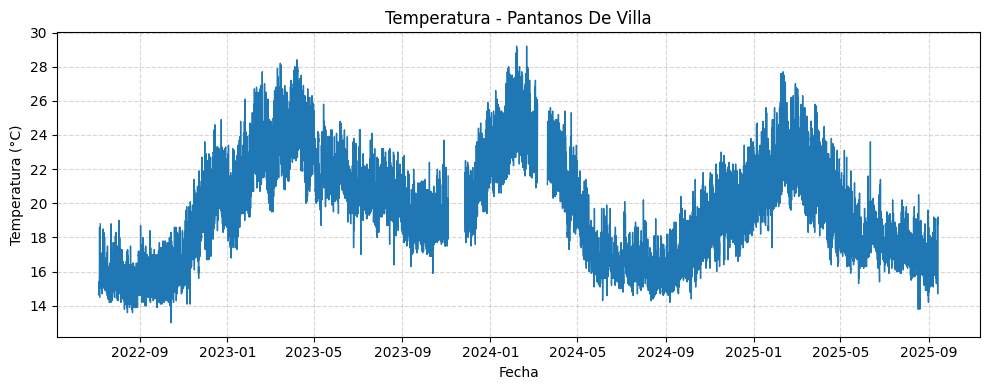

In [3]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ------------ CONFIG ------------
SCRIPT_DIR = Path.cwd()
EXCEL_FILE = SCRIPT_DIR / "senamhi_by_station.xlsx"   # <- nombre del archivo que indicaste
DATE_COL = "AÑO / MES / DÍA"
HOUR_COL = "HORA"
TEMP_COL = "TEMPERATURA (°C)"
REMOVE_TOKENS = ["MET", "EMA", "ESTACIÓN", "ESTACION", "_", "-"]
# ---------------------------------

def clean_name(name: str) -> str:
    s = str(name)
    # reemplazar guiones/underscores por espacio y quitar tokens comunes
    s = s.replace("_", " ").replace("-", " ")
    for t in REMOVE_TOKENS:
        s = re.sub(r'\b' + re.escape(t) + r'\b', '', s, flags=re.IGNORECASE)
    s = " ".join(s.split()).strip()
    return s if s else "UNKNOWN"

def make_datetime(df):
    # Crea columna datetime a partir de DATE_COL y HOUR_COL. Si no hay HORA, usa 00:00.
    if DATE_COL not in df.columns:
        raise KeyError(f"No encontré columna de fecha '{DATE_COL}' en la hoja.")
    if HOUR_COL in df.columns:
        hours = df[HOUR_COL].astype(str).str.strip().fillna("00:00")
    else:
        hours = pd.Series(["00:00"] * len(df))
    combined = df[DATE_COL].astype(str).str.strip() + " " + hours
    dt = pd.to_datetime(combined, dayfirst=False, errors='coerce')
    df = df.assign(__datetime=dt)
    df = df.dropna(subset=["__datetime"]).copy()
    df = df.set_index("__datetime").sort_index()
    return df

def read_all_sheets(path):
    print("Leyendo Excel:", path)
    xls = pd.read_excel(path, sheet_name=None, engine="openpyxl")
    stations = {}
    for sheet_name, df_raw in xls.items():
        try:
            df = df_raw.copy()
            # limpiar nombres de columna y asegurar strings
            df.columns = [str(c).strip() for c in df.columns]
            df2 = make_datetime(df)
            # convertir temperatura a numérico (NaN si hay texto)
            if TEMP_COL in df2.columns:
                df2[TEMP_COL] = pd.to_numeric(df2[TEMP_COL], errors="coerce")
            stations[clean_name(sheet_name)] = df2
            print(f"  -> hoja '{sheet_name}' cargada como '{clean_name(sheet_name)}' ({len(df2)} filas válidas).")
        except Exception as e:
            print(f"  ! Falló hoja '{sheet_name}': {e}")
    return stations

def main():
    if not EXCEL_FILE.exists():
        print("No encontré", EXCEL_FILE)
        return

    stations = read_all_sheets(EXCEL_FILE)
    if not stations:
        print("No se cargó ninguna estación.")
        return

    names = list(stations.keys())
    print("\nEstaciones disponibles:")
    print(" 0) ALL (todas las estaciones, se promedian por fecha/hora)")
    for i, n in enumerate(names, 1):
        print(f" {i}) {n}")

    sel = input(f"Elige estación por número (0-{len(names)}): ").strip()
    try:
        idx = int(sel)
    except:
        idx = 0

    if idx == 0:
        chosen = "ALL"
        # concatenar todas y mantener columna __station para posible uso
        df_all = pd.concat([df.assign(__station=name) for name, df in stations.items()], sort=False)
        # para temperatura vamos a promediar por timestamp
        df_for_plot = df_all
    elif 1 <= idx <= len(names):
        chosen = names[idx-1]
        df_for_plot = stations[chosen]
    else:
        print("Selección inválida. Usando ALL.")
        chosen = "ALL"
        df_all = pd.concat([df.assign(__station=name) for name, df in stations.items()], sort=False)
        df_for_plot = df_all

    # Mostrar primeras filas de la estación elegida
    print(f"\nSeleccionado: {chosen}")
    if TEMP_COL in df_for_plot.columns:
        print("Primeras filas (temperatura):")
        print(df_for_plot[[TEMP_COL]].head(8))
    else:
        print(f"No existe la columna de temperatura '{TEMP_COL}' en la selección.")
        return

    # Preparar serie para plot
    if chosen == "ALL":
        # promedio por timestamp (agrupamos por índice datetime)
        serie = df_for_plot.groupby(df_for_plot.index)[TEMP_COL].mean()
        title = "Temperatura - Todas las estaciones (promedio)"
    else:
        serie = df_for_plot[TEMP_COL]
        title = f"Temperatura - {chosen}"

    if serie.dropna().empty:
        print("No hay datos válidos de temperatura para graficar.")
        return

    # graficar
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, linewidth=1)
    plt.title(title)
    plt.xlabel("Fecha")
    plt.ylabel("Temperatura (°C)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Estaciones (hojas):
 0) ALL (todas las estaciones — se promedian por timestamp)
 1) Campo De Marte
 2) Carabayllo
 3) Ceres
 4) Las Palmas
 5) Pantanos De Villa
 6) San Borja
 7) San Martin De Porres EAA

Seleccionado: Carabayllo


,HUMEDAD (%)
__datetime,
2020-09-01 00:00:00,89.8
2020-09-01 01:00:00,90.4
2020-09-01 02:00:00,90.9
2020-09-01 03:00:00,90.9
2020-09-01 04:00:00,91.2
2020-09-01 05:00:00,91.6
2020-09-01 06:00:00,92.6
2020-09-01 07:00:00,93.0


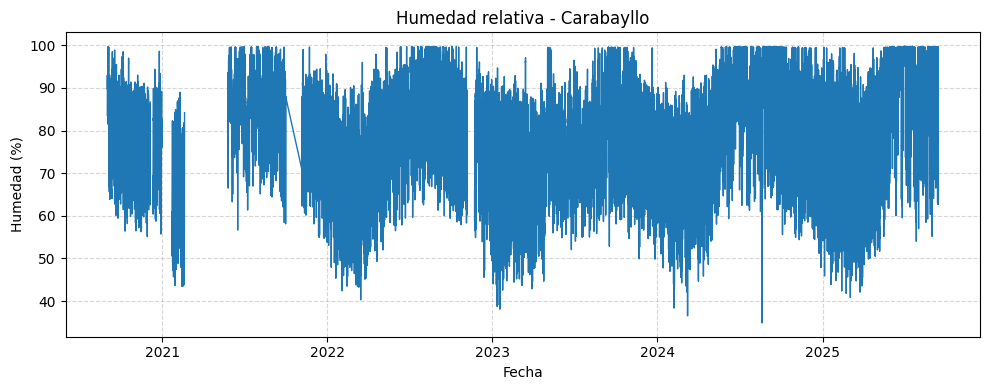

In [4]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Config
EXCEL_FILE = Path.cwd() / "senamhi_by_station.xlsx"
DATE_COL = "AÑO / MES / DÍA"
HOUR_COL = "HORA"
HUM_COL = "HUMEDAD (%)"
REMOVE_TOKENS = ["MET", "EMA", "ESTACIÓN", "ESTACION", "_", "-"]

# Helpers muy básicos
def clean_name(name: str) -> str:
    s = str(name)
    s = s.replace("_", " ").replace("-", " ")
    for t in REMOVE_TOKENS:
        s = re.sub(r'\b' + re.escape(t) + r'\b', '', s, flags=re.IGNORECASE)
    s = " ".join(s.split()).strip()
    return s if s else "UNKNOWN"

def make_datetime(df):
    if DATE_COL not in df.columns:
        raise KeyError(f"No encontré la columna de fecha '{DATE_COL}'")
    if HOUR_COL in df.columns:
        hours = df[HOUR_COL].astype(str).str.strip().fillna("00:00")
    else:
        hours = pd.Series(["00:00"] * len(df))
    combined = df[DATE_COL].astype(str).str.strip() + " " + hours
    dt = pd.to_datetime(combined, dayfirst=False, errors='coerce')
    df = df.assign(__datetime=dt)
    df = df.dropna(subset=["__datetime"]).copy()
    df = df.set_index("__datetime").sort_index()
    return df

# Leer todas las hojas del Excel
if not EXCEL_FILE.exists():
    raise FileNotFoundError(f"No encontré {EXCEL_FILE}. Pon el archivo en la carpeta del notebook.")

xls = pd.read_excel(EXCEL_FILE, sheet_name=None, engine="openpyxl")
stations = {}
for sheet_name, df_raw in xls.items():
    try:
        df_raw.columns = [str(c).strip() for c in df_raw.columns]
        df2 = make_datetime(df_raw)
        if HUM_COL in df2.columns:
            df2[HUM_COL] = pd.to_numeric(df2[HUM_COL], errors='coerce')
        stations[clean_name(sheet_name)] = df2
    except Exception as e:
        print(f"Advertencia: hoja '{sheet_name}' omitida -> {e}")

if not stations:
    raise RuntimeError("No se cargó ninguna estación válida desde el Excel.")

# Mostrar lista y seleccionar
names = list(stations.keys())
print("Estaciones (hojas):")
print(" 0) ALL (todas las estaciones — se promedian por timestamp)")
for i, n in enumerate(names, 1):
    print(f" {i}) {n}")

sel = input(f"\nElige estación por número (0-{len(names)}), enter=0: ").strip()
try:
    idx = int(sel) if sel != "" else 0
except:
    idx = 0

if idx == 0:
    chosen = "ALL"
    df_all = pd.concat([df.assign(__station=name) for name, df in stations.items()], sort=False)
    df_plot_source = df_all
else:
    if 1 <= idx <= len(names):
        chosen = names[idx-1]
        df_plot_source = stations[chosen]
    else:
        print("Selección inválida. Usando ALL.")
        chosen = "ALL"
        df_all = pd.concat([df.assign(__station=name) for name, df in stations.items()], sort=False)
        df_plot_source = df_all

# Mostrar primeras filas
print(f"\nSeleccionado: {chosen}")
if HUM_COL in df_plot_source.columns:
    display(df_plot_source[[HUM_COL]].head(8))
else:
    print(f"No existe la columna '{HUM_COL}' en la selección.")
    raise SystemExit

# Opción para filtrar año (simple)
filtrar = input("¿Filtrar por año? (s/n) [n]: ").strip().lower()
if filtrar == "s":
    y = input("Escribe el año (ej. 2022): ").strip()
    try:
        y = int(y)
        df_plot_source = df_plot_source[df_plot_source.index.year == y]
        if df_plot_source.empty:
            print("No hay datos para ese año. Saliendo.")
            raise SystemExit
    except:
        print("Año inválido. Continuando sin filtrar.")

# Preparar serie: si ALL -> promedio por timestamp, si estación -> usar su columna
if chosen == "ALL":
    serie = df_plot_source[HUM_COL].groupby(df_plot_source.index).mean()
    title = "Humedad relativa - Promedio de todas las estaciones"
else:
    serie = df_plot_source[HUM_COL]
    title = f"Humedad relativa - {chosen}"

if serie.dropna().empty:
    print("No hay datos válidos de humedad para graficar.")
else:
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, linewidth=1)
    plt.title(title)
    plt.xlabel("Fecha")
    plt.ylabel("Humedad (%)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


Estaciones (hojas):
 0) ALL (todas las estaciones -> promedia por timestamp para series; rosas también agregadas)
 1) Campo De Marte
 2) Carabayllo
 3) Ceres
 4) Las Palmas
 5) Pantanos De Villa
 6) San Borja
 7) San Martin De Porres EAA

Seleccionado: Ceres


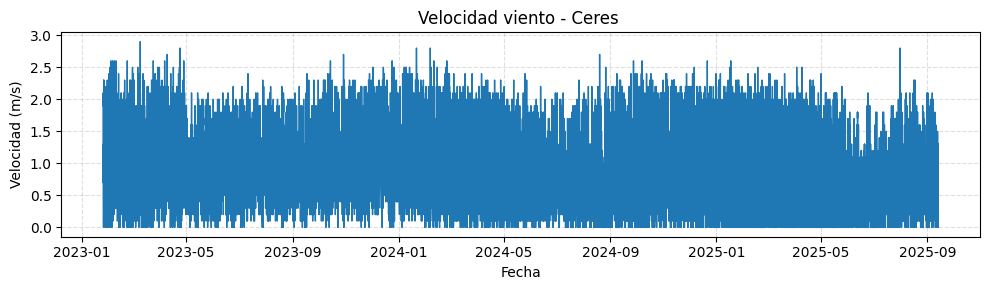

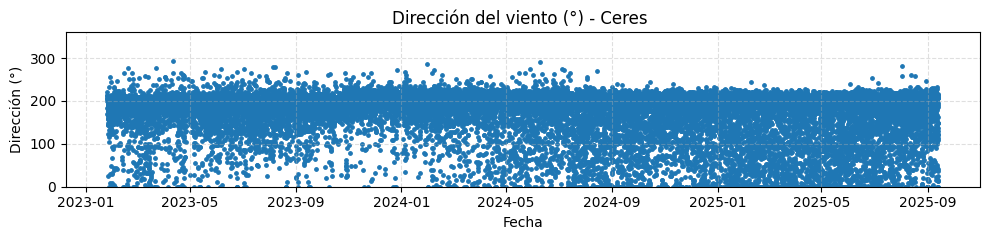

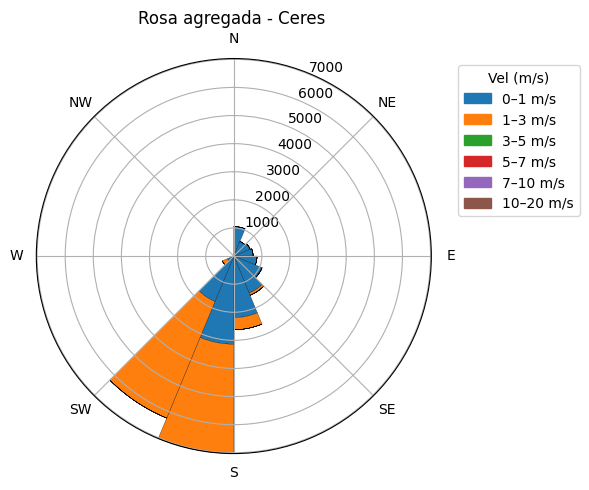

In [5]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- CONFIG simple --------
EXCEL_FILE = Path.cwd() / "senamhi_by_station.xlsx"
DATE_COL = "AÑO / MES / DÍA"
HOUR_COL = "HORA"
WDIR_COL = "DIRECCION DEL VIENTO (°)"
WSPD_COL = "VELOCIDAD DEL VIENTO (m/s)"
REMOVE_TOKENS = ["MET", "EMA", "ESTACIÓN", "ESTACION", "_", "-"]

# -------- helpers --------
def clean_name(name: str) -> str:
    s = str(name).replace("_", " ").replace("-", " ")
    for t in REMOVE_TOKENS:
        s = re.sub(r'\b' + re.escape(t) + r'\b', '', s, flags=re.IGNORECASE)
    return " ".join(s.split()).strip() or "UNKNOWN"

def make_datetime(df):
    if DATE_COL not in df.columns:
        raise KeyError(f"No encontré la columna de fecha '{DATE_COL}'")
    if HOUR_COL in df.columns:
        hours = df[HOUR_COL].astype(str).str.strip().fillna("00:00")
    else:
        hours = pd.Series(["00:00"] * len(df))
    combined = df[DATE_COL].astype(str).str.strip() + " " + hours
    dt = pd.to_datetime(combined, dayfirst=False, errors='coerce')
    df = df.assign(__datetime=dt)
    df = df.dropna(subset=["__datetime"]).copy()
    df = df.set_index("__datetime").sort_index()
    return df

def compute_windrose_counts(wdir, wspd, dir_bins=16, speed_bins=None):
    if speed_bins is None:
        speed_bins = [0, 1, 3, 5, 7, 10, 20]
    wdir = pd.to_numeric(wdir, errors='coerce')
    wspd = pd.to_numeric(wspd, errors='coerce')
    mask = (~wdir.isna()) & (~wspd.isna())
    if mask.sum() == 0:
        return np.zeros((dir_bins, len(speed_bins)-1)), speed_bins
    wdir_arr = (wdir[mask].values % 360)
    wspd_arr = wspd[mask].values
    # indices para direcciones
    dir_idx = (np.floor(wdir_arr / (360.0 / dir_bins))).astype(int) % dir_bins
    sp_idx = np.digitize(wspd_arr, speed_bins) - 1
    n_sp = len(speed_bins)-1
    counts = np.zeros((dir_bins, n_sp), dtype=float)
    for d, s in zip(dir_idx, sp_idx):
        if 0 <= s < n_sp:
            counts[d, s] += 1
    return counts, speed_bins

def plot_wind_rose_from_counts(counts, speed_bins, dir_bins=16, ax=None, title=None):
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, polar=True)
    width = 2 * np.pi / dir_bins
    angles = np.linspace(0.0, 2*np.pi, dir_bins, endpoint=False)
    bottom = np.zeros(dir_bins)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_sp = counts.shape[1]
    for i in range(n_sp):
        vals = counts[:, i]
        ax.bar(angles, vals, width=width, bottom=bottom, align='edge',
               edgecolor='k', linewidth=0.2, color=colors[i % len(colors)])
        bottom += vals
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
    ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW'])
    if title:
        ax.set_title(title)
    # legend
    labels = [f"{speed_bins[i]}–{speed_bins[i+1]} m/s" for i in range(len(speed_bins)-1)]
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=colors[i % len(colors)], label=labels[i]) for i in range(len(labels))]
    ax.legend(handles=patches, title="Vel (m/s)", bbox_to_anchor=(1.05,1), loc='upper left')
    return ax

# -------- load sheets --------
if not EXCEL_FILE.exists():
    raise FileNotFoundError(f"No encontré {EXCEL_FILE} en la carpeta del notebook.")

xls = pd.read_excel(EXCEL_FILE, sheet_name=None, engine="openpyxl")
stations = {}
for sheet_name, df_raw in xls.items():
    df_raw.columns = [str(c).strip() for c in df_raw.columns]
    try:
        df = make_datetime(df_raw)
    except Exception as e:
        print(f"Hoja '{sheet_name}' omitida (fecha):", e)
        continue
    # convertir columnas si existen
    if WDIR_COL in df.columns:
        df[WDIR_COL] = pd.to_numeric(df[WDIR_COL], errors='coerce')
    if WSPD_COL in df.columns:
        df[WSPD_COL] = pd.to_numeric(df[WSPD_COL], errors='coerce')
    stations[clean_name(sheet_name)] = df

if not stations:
    raise RuntimeError("No se cargó ninguna hoja válida del Excel.")

# -------- choose station --------
names = list(stations.keys())
print("Estaciones (hojas):")
print(" 0) ALL (todas las estaciones -> promedia por timestamp para series; rosas también agregadas)")
for i, n in enumerate(names, 1):
    print(f" {i}) {n}")
sel = input(f"Elige estación por número (0-{len(names)}), enter=0: ").strip()
try:
    idx = int(sel) if sel != "" else 0
except:
    idx = 0

if idx == 0:
    chosen = "ALL"
    df_all = pd.concat([df.assign(__station=name) for name, df in stations.items()], sort=False)
    df_src = df_all
else:
    if 1 <= idx <= len(names):
        chosen = names[idx-1]
        df_src = stations[chosen]
    else:
        print("Selección inválida -> ALL")
        chosen = "ALL"
        df_all = pd.concat([df.assign(__station=name) for name, df in stations.items()], sort=False)
        df_src = df_all

print(f"\nSeleccionado: {chosen}")

# optional: filter by year
year_choice = None
filter_year = input("¿Filtrar por año antes de graficar? (s/n) [n]: ").strip().lower()
if filter_year == "s":
    y = input("Ingresa año (ej. 2022): ").strip()
    try:
        y = int(y)
        df_src = df_src[df_src.index.year == y]
        year_choice = y
        if df_src.empty:
            print("No hay datos para ese año. Saliendo.")
            raise SystemExit
    except:
        print("Año inválido. Continuando sin filtrar.")

# -------- Time series plots (wind speed + direction as scatter) --------
if WSPD_COL not in df_src.columns and WDIR_COL not in df_src.columns:
    print(f"No encontré columnas de viento '{WSPD_COL}' ni '{WDIR_COL}' en la selección.")
else:
    # Wind speed series
    if WSPD_COL in df_src.columns:
        if chosen == "ALL":
            wspd_ts = df_src.groupby(df_src.index)[WSPD_COL].mean()
            title_wspd = f"Velocidad viento (promedio estaciones) {'- '+str(year_choice) if year_choice else ''}"
        else:
            wspd_ts = df_src[WSPD_COL]
            title_wspd = f"Velocidad viento - {chosen} {'- '+str(year_choice) if year_choice else ''}"
        if not wspd_ts.dropna().empty:
            plt.figure(figsize=(10,3))
            plt.plot(wspd_ts.index, wspd_ts.values, linewidth=1)
            plt.title(title_wspd)
            plt.ylabel("Velocidad (m/s)")
            plt.xlabel("Fecha")
            plt.grid(True, linestyle="--", alpha=0.4)
            plt.tight_layout()
            plt.show()
        else:
            print("No hay datos válidos de velocidad para graficar.")

    # Wind direction as dot plot (circular wrap shown as values)
    if WDIR_COL in df_src.columns:
        wdir_series = df_src[WDIR_COL] if chosen != "ALL" else df_src.groupby(df_src.index)[WDIR_COL].mean()
        if not wdir_series.dropna().empty:
            plt.figure(figsize=(10,2.5))
            plt.scatter(wdir_series.index, wdir_series.values, s=6)
            plt.title(f"Dirección del viento (°) - {chosen} {'- '+str(year_choice) if year_choice else ''}")
            plt.ylabel("Dirección (°)")
            plt.ylim(0, 360)
            plt.xlabel("Fecha")
            plt.grid(True, linestyle="--", alpha=0.4)
            plt.tight_layout()
            plt.show()
        else:
            print("No hay datos válidos de dirección para graficar.")

# -------- Wind rose(s) interface (very basic) --------
if (WDIR_COL in df_src.columns) and (WSPD_COL in df_src.columns):
    opt = input("Generar rosas de viento: (1) 12 rosas mensuales (2) 1 rosa agregada (enter=2): ").strip() or "2"
    if opt == "1":
        # 12 monthly roses in 2x6
        fig = plt.figure(figsize=(18,8))
        for i, m in enumerate(range(1,13), 1):
            sub = df_src[df_src.index.month == m]
            counts, sb = compute_windrose_counts(sub[WDIR_COL], sub[WSPD_COL], dir_bins=16)
            ax = fig.add_subplot(2,6,i, polar=True)
            plot_wind_rose_from_counts(counts, sb, dir_bins=16, ax=ax, title=f"Mes {m}")
        plt.tight_layout()
        plt.show()
    else:
        # aggregated rose
        counts, sb = compute_windrose_counts(df_src[WDIR_COL], df_src[WSPD_COL], dir_bins=16)
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, polar=True)
        plot_wind_rose_from_counts(counts, sb, dir_bins=16, ax=ax,
                                   title=f"Rosa agregada - {chosen} {'- '+str(year_choice) if year_choice else ''}")
        plt.tight_layout()
        plt.show()
else:
    print("No es posible generar rosas: faltan columnas de dirección y/o velocidad.")


Leyendo hojas de: senamhi_by_station.xlsx
  -> hoja 'Campo_De_Marte_MET_EMA' cargada como 'Campo De Marte' (43194 filas válidas)
  -> hoja 'Carabayllo_MET_EMA' cargada como 'Carabayllo' (39135 filas válidas)
  -> hoja 'Ceres_MET_EMA' cargada como 'Ceres' (22799 filas válidas)
  -> hoja 'Las_Palmas_MET_EMA' cargada como 'Las Palmas' (20418 filas válidas)
  -> hoja 'Pantanos_De_Villa_MET_EMA' cargada como 'Pantanos De Villa' (27899 filas válidas)
  -> hoja 'San_Borja_MET_EMA' cargada como 'San Borja' (38678 filas válidas)
  -> hoja 'San_Martin_De_Porres_MET_EAA' cargada como 'San Martin De Porres EAA' (42607 filas válidas)

Estaciones disponibles:
 1) Campo De Marte
 2) Carabayllo
 3) Ceres
 4) Las Palmas
 5) Pantanos De Villa
 6) San Borja
 7) San Martin De Porres EAA
Seleccionada: Campo De Marte (filas: 43194)

Variables disponibles:
 1) Temperatura (°C)
 2) Humedad (%)
 3) Precipitación (mm/hora)
 4) Velocidad viento (m/s)
 5) Dirección viento (°)
Variable elegida: Precipitación (mm/h

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23380\2319187356.py:188: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = df_year[var_col].resample('M').sum(min_count=1).fillna(0)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23380\2319187356.py:199: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_periods = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='M')


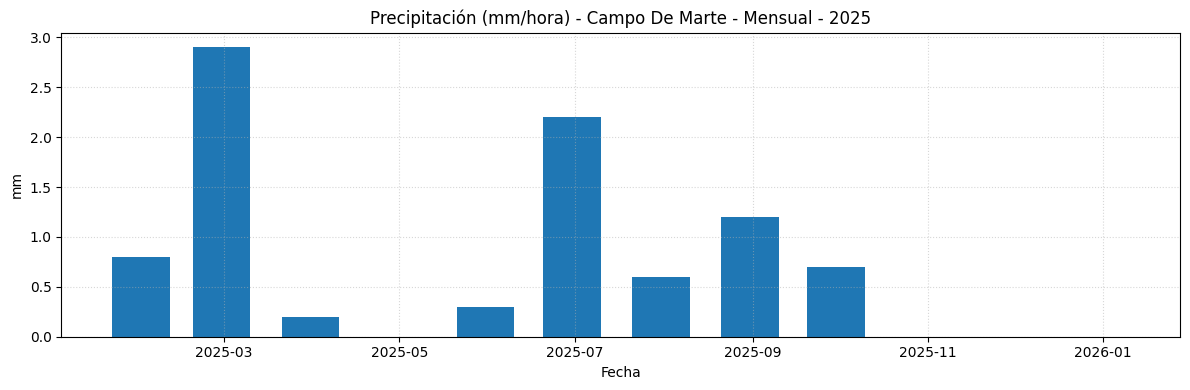


Tabla agregada (index, value):


,value
2025-01,0.8
2025-02,2.9
2025-03,0.2
2025-04,0.0
2025-05,0.3
2025-06,2.2
2025-07,0.6
2025-08,1.2
2025-09,0.7
2025-10,0.0



--- Fin ---


In [6]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
EXCEL_FILE = Path.cwd() / "senamhi_by_station.xlsx"   # cada hoja = una estación
DATE_COL = "AÑO / MES / DÍA"
HOUR_COL = "HORA"
# columnas típicas (ajusta si tus nombres son diferentes)
COL_TEMP = "TEMPERATURA (°C)"
COL_PREC = "PRECIPITACIÓN (mm/hora)"
COL_HUM = "HUMEDAD (%)"
COL_WDIR = "DIRECCION DEL VIENTO (°)"
COL_WSPD = "VELOCIDAD DEL VIENTO (m/s)"
REMOVE_TOKENS = ["MET", "EMA", "ESTACIÓN", "ESTACION", "_", "-"]

# ---------- helpers ----------
def clean_name(name: str) -> str:
    s = str(name)
    s = s.replace("_", " ").replace("-", " ")
    for t in REMOVE_TOKENS:
        s = re.sub(r'\b' + re.escape(t) + r'\b', '', s, flags=re.IGNORECASE)
    return " ".join(s.split()).strip() or "UNKNOWN"

def normalize_hour(h):
    if pd.isna(h):
        return "00:00"
    s = str(h).strip()
    if ":" in s:
        parts = s.split(":")
        try:
            hh = int(parts[0]); mm = int(parts[1]) if len(parts)>1 else 0
            return f"{hh:02d}:{mm:02d}"
        except:
            return "00:00"
    try:
        hh = int(float(s))
        return f"{hh:02d}:00"
    except:
        return "00:00"

def make_datetime(df):
    if DATE_COL not in df.columns:
        raise KeyError(f"No encontré columna de fecha '{DATE_COL}' en la hoja.")
    if HOUR_COL in df.columns:
        hours = df[HOUR_COL].apply(normalize_hour)
    else:
        hours = pd.Series(["00:00"] * len(df), index=df.index)
    combined = df[DATE_COL].astype(str).str.strip() + " " + hours
    dt = pd.to_datetime(combined, dayfirst=False, errors='coerce')
    df = df.assign(__datetime=dt)
    before = len(df)
    df = df.dropna(subset=["__datetime"]).copy()
    after = len(df)
    if after < before:
        print(f"  (Se descartaron {before-after} filas sin datetime válido)")
    df = df.set_index("__datetime").sort_index()
    return df

def circular_mean_deg(series):
    vals = pd.to_numeric(series, errors='coerce').dropna()
    if vals.empty:
        return np.nan
    rad = np.deg2rad(vals % 360)
    s = np.sin(rad).mean()
    c = np.cos(rad).mean()
    ang = np.rad2deg(np.arctan2(s, c)) % 360
    return ang

# ---------- load sheets ----------
if not EXCEL_FILE.exists():
    raise FileNotFoundError(f"No encontré {EXCEL_FILE}. Pon el archivo en la carpeta del notebook.")

print("Leyendo hojas de:", EXCEL_FILE.name)
raw = pd.read_excel(EXCEL_FILE, sheet_name=None, engine="openpyxl")
stations = {}
for sheet, df_raw in raw.items():
    try:
        df_raw.columns = [str(c).strip() for c in df_raw.columns]
        df = make_datetime(df_raw)
        # convertir columnas numéricas cuando existan
        for c in [COL_TEMP, COL_PREC, COL_HUM, COL_WDIR, COL_WSPD]:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce')
        stations[clean_name(sheet)] = df
        print(f"  -> hoja '{sheet}' cargada como '{clean_name(sheet)}' ({len(df)} filas válidas)")
    except Exception as e:
        print(f"  ! Hoja '{sheet}' omitida: {e}")

if not stations:
    raise RuntimeError("No se cargó ninguna hoja válida del Excel.")

# ---------- seleccionar estación ----------
names = list(stations.keys())
print("\nEstaciones disponibles:")
for i, n in enumerate(names, 1):
    print(f" {i}) {n}")
sel = input(f"Elige estación por número (1-{len(names)}): ").strip()
try:
    idx = int(sel)
    assert 1 <= idx <= len(names)
except:
    print("Selección inválida. Usando 1.")
    idx = 1
chosen = names[idx-1]
df = stations[chosen]
print(f"Seleccionada: {chosen} (filas: {len(df)})")

# ---------- elegir variable ----------
available = []
col_map = {}
if COL_TEMP in df.columns:
    available.append("Temperatura (°C)"); col_map["Temperatura (°C)"] = COL_TEMP
if COL_HUM in df.columns:
    available.append("Humedad (%)"); col_map["Humedad (%)"] = COL_HUM
if COL_PREC in df.columns:
    available.append("Precipitación (mm/hora)"); col_map["Precipitación (mm/hora)"] = COL_PREC
if COL_WSPD in df.columns:
    available.append("Velocidad viento (m/s)"); col_map["Velocidad viento (m/s)"] = COL_WSPD
if COL_WDIR in df.columns:
    available.append("Dirección viento (°)"); col_map["Dirección viento (°)"] = COL_WDIR

if not available:
    raise RuntimeError("No se encontraron columnas válidas en la hoja seleccionada.")

print("\nVariables disponibles:")
for i, v in enumerate(available, 1):
    print(f" {i}) {v}")
vsel = input(f"Elige variable (1-{len(available)}): ").strip()
try:
    vi = int(vsel)
    assert 1 <= vi <= len(available)
except:
    print("Selección inválida. Usando 1.")
    vi = 1
var_label = available[vi-1]
var_col = col_map[var_label]
print("Variable elegida:", var_label)

# ---------- elegir año ----------
years = sorted(df.index.year.unique())
print("\nAños disponibles:", years)
y_in = input("Escribe el año a graficar (enter = último disponible): ").strip()
if y_in == "":
    year = years[-1]
else:
    try:
        year = int(y_in)
        if year not in years:
            print("Año no disponible; usando último disponible.")
            year = years[-1]
    except:
        print("Año inválido; usando último disponible.")
        year = years[-1]
print("Año elegido:", year)

# ---------- elegir agregación ----------
print("\nTipo de agregación:")
print(" 1) Diario")
print(" 2) Mensual")
a = input("Elige 1 o 2: ").strip()
if a == "1":
    freq_label = "D"
    agg_label = "Diario"
else:
    freq_label = "M"
    agg_label = "Mensual"
print("Agregación:", agg_label)

# ---------- agrupar y calcular ---------- 
df_year = df[df.index.year == year]
if df_year.empty:
    raise RuntimeError("No hay datos para ese año seleccionado.")

if var_label == "Dirección viento (°)":
    # usar media circular por periodo
    if freq_label == "D":
        grouped = df_year[var_col].resample('D').apply(circular_mean_deg)
    else:
        grouped = df_year[var_col].resample('M').apply(circular_mean_deg)
elif var_label == "Precipitación (mm/hora)":
    # sumar para precipitación
    if freq_label == "D":
        grouped = df_year[var_col].resample('D').sum(min_count=1).fillna(0)
    else:
        grouped = df_year[var_col].resample('M').sum(min_count=1).fillna(0)
else:
    # temperatura, humedad, velocidad -> media
    if freq_label == "D":
        grouped = df_year[var_col].resample('D').mean()
    else:
        grouped = df_year[var_col].resample('M').mean()

# limpiar índice para plotting (asegurar 0..11 months shown when monthly)
if freq_label == "M":
    # reindex to all months of year to show missing months as NaN/0 (for precip use 0)
    all_periods = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='M')
    grouped = grouped.reindex(all_periods)
    if var_label == "Precipitación (mm/hora)":
        grouped = grouped.fillna(0)

# ---------- plotting ----------
plt.figure(figsize=(12,4))
title = f"{var_label} - {chosen} - {agg_label} - {year}"
if var_label == "Precipitación (mm/hora)":
    # barras
    x = grouped.index
    y = grouped.values
    plt.bar(x, y, width=20 if freq_label=="D" else 20, align='center')
    plt.ylabel("mm")
else:
    plt.plot(grouped.index, grouped.values, marker='o', linewidth=1)
    plt.ylabel(var_label)
plt.title(title)
plt.xlabel("Fecha")
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

# ---------- mostrar tabla con valores agregados ----------
print("\nTabla agregada (index, value):")
display_df = pd.DataFrame({'value': grouped.values}, index=grouped.index)
# para monthly index nicer labels
if freq_label == "M":
    display_df.index = [d.strftime("%Y-%m") for d in grouped.index]
else:
    display_df.index = [d.strftime("%Y-%m-%d") for d in grouped.index]
display(display_df.head(400))

print("\n--- Fin ---")


Estaciones disponibles:
 0) ALL (promedio entre estaciones)
 1) Campo De Marte
 2) Ceres
 3) Las Palmas
 4) Pantanos De Villa
 5) San Borja
 6) San Martin De Porres EAA
Años disponibles: [2020, 2021, 2022, 2023, 2024, 2025]


C:\Users\COMPUTER\AppData\Local\Temp\ipykernel_9608\1312719999.py:147: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = df_year[PREC_COL].resample('M').sum(min_count=1)
C:\Users\COMPUTER\AppData\Local\Temp\ipykernel_9608\1312719999.py:148: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = monthly_series.reindex(pd.date_range(f"{year}-01-31", f"{year}-12-31", freq='M'))


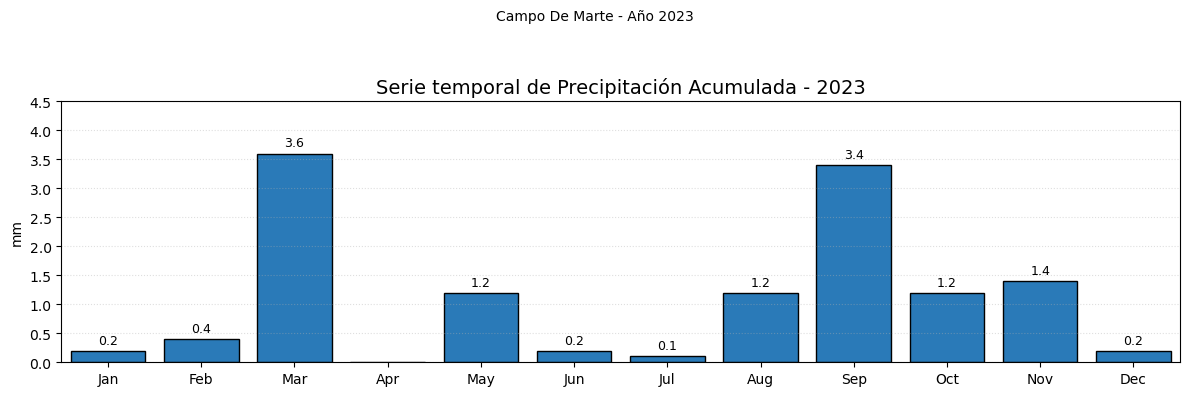


Precipitación acumulada por mes (mm):


,month,precip_mm
0,Jan,0.2
1,Feb,0.4
2,Mar,3.6
3,Apr,0.0
4,May,1.2
5,Jun,0.2
6,Jul,0.1
7,Aug,1.2
8,Sep,3.4
9,Oct,1.2


In [4]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
EXCEL_FILE = Path.cwd() / "senamhi_by_station.xlsx"
CSV_FALLBACK = Path.cwd() / "senamhi_merged.csv"
DATE_COL = "AÑO / MES / DÍA"
HOUR_COL = "HORA"
PREC_COL = "PRECIPITACIÓN (mm/hora)"
REMOVE_TOKENS = ["MET","EMA","ESTACIÓN","ESTACION","_","-"]

# ---------- helpers ----------
def clean_name(name: str) -> str:
    s = str(name).replace("_", " ").replace("-", " ")
    for t in REMOVE_TOKENS:
        s = re.sub(r'\b' + re.escape(t) + r'\b', '', s, flags=re.IGNORECASE)
    s = " ".join(s.split()).strip()
    return s or "UNKNOWN"

def normalize_hour(h):
    if pd.isna(h): return "00:00"
    s = str(h).strip()
    if ":" in s:
        parts = s.split(":")
        try:
            hh = int(parts[0]); mm = int(parts[1]) if len(parts)>1 else 0
            return f"{hh:02d}:{mm:02d}"
        except:
            return "00:00"
    try:
        hh = int(float(s)); return f"{hh:02d}:00"
    except:
        return "00:00"

def make_datetime(df):
    if DATE_COL not in df.columns:
        raise KeyError(f"No encontré la columna de fecha '{DATE_COL}'.")
    if HOUR_COL in df.columns:
        hours = df[HOUR_COL].apply(normalize_hour)
    else:
        hours = pd.Series(["00:00"]*len(df), index=df.index)
    combined = df[DATE_COL].astype(str).str.strip() + " " + hours
    dt = pd.to_datetime(combined, dayfirst=False, errors='coerce')
    df = df.assign(__dt=dt)
    df = df.dropna(subset=["__dt"]).copy()
    df = df.set_index("__dt").sort_index()
    return df

# ---------- cargar datos ----------
if EXCEL_FILE.exists():
    raw = pd.read_excel(EXCEL_FILE, sheet_name=None, engine="openpyxl")
    stations = {}
    for sheet, raw_df in raw.items():
        try:
            raw_df.columns = [str(c).strip() for c in raw_df.columns]
            df = make_datetime(raw_df)
            # detectar columna de precipitación
            if PREC_COL not in df.columns:
                cand = [c for c in df.columns if "PRECIP" in str(c).upper() or "PREC" in str(c).upper()]
                if cand:
                    df[PREC_COL] = pd.to_numeric(df[cand[0]], errors='coerce')
                else:
                    continue
            else:
                df[PREC_COL] = pd.to_numeric(df[PREC_COL], errors='coerce')
            stations[clean_name(sheet)] = df
        except Exception:
            continue
elif CSV_FALLBACK.exists():
    raw_df = pd.read_csv(CSV_FALLBACK, encoding='utf-8', low_memory=False)
    raw_df.columns = [str(c).strip() for c in raw_df.columns]
    df = make_datetime(raw_df)
    if PREC_COL not in df.columns:
        cand = [c for c in df.columns if "PRECIP" in str(c).upper() or "PREC" in str(c).upper()]
        if cand:
            df[PREC_COL] = pd.to_numeric(df[cand[0]], errors='coerce')
    else:
        df[PREC_COL] = pd.to_numeric(df[PREC_COL], errors='coerce')
    stations = {"ALL": df}
else:
    raise FileNotFoundError("No encontré 'senamhi_by_station.xlsx' ni 'senamhi_merged.csv'.")

if not stations:
    raise RuntimeError("No se cargó ninguna estación con datos de precipitación.")

# ---------- seleccionar estación ----------
names = list(stations.keys())
print("Estaciones disponibles:")
print(" 0) ALL (promedio entre estaciones)")
for i,n in enumerate(names,1):
    print(f" {i}) {n}")
sel = input(f"Elige estación (0-{len(names)}), enter=0: ").strip()
try:
    idx = int(sel) if sel!="" else 0
except:
    idx = 0
if idx == 0:
    chosen = "ALL"
else:
    chosen = names[idx-1] if 1 <= idx <= len(names) else "ALL"

# ---------- elegir año ----------
if chosen == "ALL":
    years_all = sorted({y for df in stations.values() for y in df.index.year.unique()})
else:
    years_all = sorted(stations[chosen].index.year.unique())
if not years_all:
    raise RuntimeError("No hay años disponibles.")
print("Años disponibles:", years_all)
y_in = input("Año a plotear (enter = último): ").strip()
if y_in == "":
    year = int(years_all[-1])
else:
    try:
        year = int(y_in)
        if year not in years_all:
            year = int(years_all[-1])
    except:
        year = int(years_all[-1])

# ---------- calcular mensual ----------
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

if chosen == "ALL":
    monthly_per_station = []
    for stname, st_df in stations.items():
        st_year = st_df[st_df.index.year == year]
        if st_year.empty:
            continue
        monthly = st_year[PREC_COL].resample('M').sum(min_count=1)
        # reindex to ensure months present
        monthly = monthly.reindex(pd.date_range(f"{year}-01-31", f"{year}-12-31", freq='M'))
        monthly_per_station.append(monthly.values)
    if not monthly_per_station:
        raise RuntimeError("No hay datos de precipitación para ese año.")
    arr = np.vstack(monthly_per_station)
    monthly_values = np.nanmean(arr, axis=0)
    subtitle = f"Promedio mensual entre estaciones ({arr.shape[0]} estaciones) - {year}"
else:
    df_choice = stations[chosen]
    df_year = df_choice[df_choice.index.year == year]
    if df_year.empty:
        raise RuntimeError("No hay datos para ese año en la estación seleccionada.")
    monthly_series = df_year[PREC_COL].resample('M').sum(min_count=1)
    monthly_series = monthly_series.reindex(pd.date_range(f"{year}-01-31", f"{year}-12-31", freq='M'))
    monthly_values = monthly_series.values
    subtitle = f"{chosen} - Año {year}"

# ---------- plot (corregido) ----------
x = np.arange(1,13)
y = np.nan_to_num(monthly_values, nan=0.0)

fig, ax = plt.subplots(figsize=(12,4))
fig.suptitle(subtitle, fontsize=10, y=0.98)
ax.set_title(f"Serie temporal de Precipitación Acumulada - {year}", fontsize=14)
bars = ax.bar(x, y, color='#2A7AB8', edgecolor='black')

# ajustar límite superior para que etiquetas no se corten
y_max = max(y.max(), 0.1)
ax.set_ylim(0, y_max * 1.25)

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_xlim(0.5, 12.5)
ax.set_ylabel("mm")
ax.grid(axis='y', linestyle=':', alpha=0.4)

# anotar valores sobre barras (solo si valor > 0)
for b, val in zip(bars, y):
    if val is None or np.isnan(val) or val == 0:
        continue
    h = b.get_height()
    offset = max(y_max * 0.02, 0.05)   # separación dinámica
    ax.text(b.get_x() + b.get_width()/2, h + offset, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# ---------- mostrar tabla ----------
df_monthly = pd.DataFrame({'month': month_labels, 'precip_mm': list(y)})
print("\nPrecipitación acumulada por mes (mm):")
display(df_monthly)
